In [1]:
%matplotlib inline


# DC Resistivity Forward Simulation in 2.5D

Here we use the module *SimPEG.electromagnetics.static.resistivity* to predict
DC resistivity data. In this tutorial, we focus on the following:

    - How to define the survey
    - How to define the forward simulation
    - How to predict DC resistivity data for a synthetic resistivity model
    - How to include surface topography
    - The units of the model and resulting data


## Import modules




In [2]:
from discretize import TensorMesh
from discretize.utils import mkvc, refine_tree_xyz

from SimPEG.utils import model_builder, surface2ind_topo
from SimPEG import maps, data
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_survey_line,
    plot_pseudoSection,
)

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

save_file = False

In [3]:
# ------ Defining Topography

x_topo, y_topo = np.meshgrid(
    np.linspace(-300, 300, 101), np.linspace(-300, 300, 101)
)
z_topo = 0 * ((1 / np.pi) * 85 * (-np.pi / 2 + np.arctan((np.abs(x_topo) - 600.0) / 50.0)))
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

## Create Dipole-Dipole Survey

Here we define a single EW survey line that uses a dipole-dipole configuration.
For the source, we must define the AB electrode locations. For the receivers
we must define the MN electrode locations. Instead of creating the survey
from scratch (see 1D example), we will use the *generat_dcip_survey_line* utility.




In [4]:
# Load data - tirado daqui:  https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_inv_2_dcr2d.html#load-data-define-survey-and-plot
dobs = np.loadtxt(str('dc_data.txt'))

# Extract source and receiver electrode locations and the observed data
# a segunda coluna é a coordenada de elevação
A_electrodes = dobs[:, 0:2]/100
B_electrodes = dobs[:, 2:4]/100
M_electrodes = dobs[:, 4:6]/100
N_electrodes = dobs[:, 6:8]/100


A_electrodes[:, 1] = 0
B_electrodes[:, 1] = 0
M_electrodes[:, 1] = 0
N_electrodes[:, 1] = 0


In [5]:
M_electrodes

array([[-3.625,  0.   ],
       [-3.125,  0.   ],
       [-2.625,  0.   ],
       [-2.125,  0.   ],
       [-1.625,  0.   ],
       [-1.125,  0.   ],
       [-0.625,  0.   ],
       [-0.125,  0.   ],
       [-3.125,  0.   ],
       [-2.625,  0.   ],
       [-2.125,  0.   ],
       [-1.625,  0.   ],
       [-1.125,  0.   ],
       [-0.625,  0.   ],
       [-0.125,  0.   ],
       [ 0.375,  0.   ],
       [-2.625,  0.   ],
       [-2.125,  0.   ],
       [-1.625,  0.   ],
       [-1.125,  0.   ],
       [-0.625,  0.   ],
       [-0.125,  0.   ],
       [ 0.375,  0.   ],
       [ 0.875,  0.   ],
       [-2.125,  0.   ],
       [-1.625,  0.   ],
       [-1.125,  0.   ],
       [-0.625,  0.   ],
       [-0.125,  0.   ],
       [ 0.375,  0.   ],
       [ 0.875,  0.   ],
       [ 1.375,  0.   ],
       [-1.625,  0.   ],
       [-1.125,  0.   ],
       [-0.625,  0.   ],
       [-0.125,  0.   ],
       [ 0.375,  0.   ],
       [ 0.875,  0.   ],
       [ 1.375,  0.   ],
       [ 1.875,  0.   ],


In [6]:
# Define survey - tirado daqui:  https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_inv_2_dcr2d.html#load-data-define-survey-and-plot

unique_tx, k = np.unique(np.c_[A_electrodes, B_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.r_[k, len(A_electrodes) + 1]

source_list = []
for ii in range(0, n_sources):

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = M_electrodes[k[ii] : k[ii + 1], :]
    N_locations = N_electrodes[k[ii] : k[ii + 1], :]
    receiver_list = [dc.receivers.Dipole(M_locations, N_locations, data_type="volt")]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = A_electrodes[k[ii], :]
    B_location = B_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.survey.Survey_ky(source_list)

## Create OcTree Mesh

Here, we create the OcTree mesh that will be used to predict both DC
resistivity and IP data.




In [8]:
# ------ Create OcTree Mesh

dh = 0.01  # base cell width
dom_width_x = 20.0  # domain width x em metros
dom_width_z = 5.0  # domain width z em metros
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z


# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TensorMesh([hx, hz], x0="CN")

"""# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh, xyz_topo[:, [0, 2]], octree_levels=[1], method="surface", finalize=False
)


# Mesh refinement near transmitters and receivers. First we need to obtain the
# set of unique electrode locations.
electrode_locations = np.c_[
    survey.locations_a, survey.locations_b, survey.locations_m, survey.locations_n
]

unique_locations = np.unique(
    np.reshape(electrode_locations, (4 * survey.nD, 2)), axis=0
)

mesh = refine_tree_xyz(
    mesh, unique_locations, octree_levels=[2, 4], method="radial", finalize=False
)

# Refine core mesh region
xp, zp = np.meshgrid([-10.0, 10.0], [-2.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(zp)]
mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2, 2], method="box", finalize=False)"""



#mesh.finalize()




# ------ Create Conductivity Model and Mapping for OcTree Mesh

# Define conductivity model in S/m (or resistivity model in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

# Find active cells in forward modeling (cell below surface)
ind_active = surface2ind_topo(mesh, xyz_topo[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum())
conductivity_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define model
conductivity_model = background_conductivity * np.ones(nC)

ind_conductor = model_builder.getIndicesSphere(np.r_[-5.0, -1.0], 0.25, mesh.gridCC)
ind_conductor = ind_conductor[ind_active]
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.getIndicesSphere(np.r_[5.0, -1.0], 0.25, mesh.gridCC)
ind_resistor = ind_resistor[ind_active]
conductivity_model[ind_resistor] = resistor_conductivity

## Create Conductivity Model and Mapping for OcTree Mesh

Here we define the conductivity model that will be used to predict DC
resistivity data. The model consists of a conductive sphere and a
resistive sphere within a moderately conductive background. Note that
you can carry through this work flow with a resistivity model if desired.




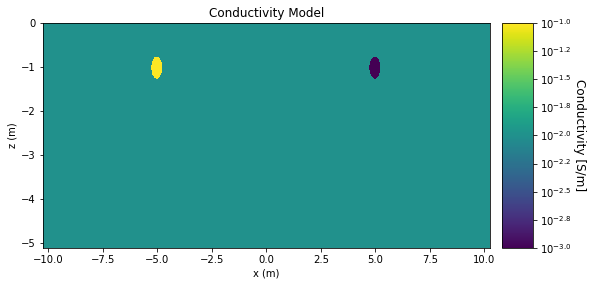

In [9]:
# Plot Conductivity Model
fig = plt.figure(figsize=(8.5, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
log_mod = np.log10(conductivity_model)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotImage(
    plotting_map * log_mod,
    ax=ax1,
    grid=False,
    clim=(np.log10(resistor_conductivity), np.log10(conductor_conductivity)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(
    vmin=np.log10(resistor_conductivity), vmax=np.log10(conductor_conductivity)
)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, cmap=mpl.cm.viridis, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

## Project Survey to Discretized Topography

It is important that electrodes are not model as being in the air. Even if the
electrodes are properly located along surface topography, they may lie above
the discretized topography. This step is carried out to ensure all electrodes
like on the discretized surface.




In [10]:
survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

## Predict DC Resistivity Data

Here we predict DC resistivity data. If the keyword argument *sigmaMap* is
defined, the simulation will expect a conductivity model. If the keyword
argument *rhoMap* is defined, the simulation will expect a resistivity model.




In [11]:
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map, Solver=Solver
)

# Predict the data by running the simulation. The data are the raw voltage in
# units of volts.
dpred = simulation.dpred(conductivity_model)

# Define a data object (required for pseudo-section plot)
data_obj = data.Data(survey, dobs=dpred)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plot_pseudoSection(
    data_obj,
    ax=ax1,
    survey_type="dipole-dipole",
    data_type="appResistivity",
    space_type="half-space",
    scale="log",
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Apparent Resistivity [Ohm.m]")

plt.show()

KeyboardInterrupt: 